In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import math


## Geração de features

In [2]:
def load_and_prepare_data(file_path):
    cols_wanted = ['data_hora_fato', 'natureza_descricao', 'numero_latitude', 'numero_longitude']
    df = pd.read_csv(file_path, usecols=cols_wanted)
    df['data_hora_fato'] = pd.to_datetime(df['data_hora_fato'], errors='coerce')
    df=df.dropna()
    df = df[df['data_hora_fato'].dt.year == 2024]
    df = df[df['natureza_descricao'] == 'FURTO']
    # Ordenar o DataFrame por data
    df = df.sort_values(by='data_hora_fato')
    
    # Filtrar os primeiros 7 meses
    start_date = df['data_hora_fato'].min()
    end_date = start_date + pd.DateOffset(months=7)
    df = df[(df['data_hora_fato'] >= start_date) & (df['data_hora_fato'] < end_date)]

    return df

def read_df_offline(df_path):
    df = pd.read_csv(df_path)
    # df = df[config['database']['columns']]
    # df['data_hora_fato'] = pd.to_datetime(df['data_hora_fato'])
    # df = df.query(f"'{config['database']['filters']['start_date']}'\
    #                 <= data_hora_fato <= \
    #                 '{config['database']['filters']['end_date']}'")
    return df

df_path = "/home/matheuspimenta/Jobs/PM/dados_BH.csv"
df = load_and_prepare_data(df_path)

In [3]:
df.head()
print(df["data_hora_fato"].min(), df["data_hora_fato"].max())

2024-01-01 00:00:00 2024-07-31 23:33:55


In [4]:
# df = df[df["natureza_descricao"] == "FURTO"]
# df = df[df["nome_municipio"] == "BELO HORIZONTE"]
# df.head()
df = df.dropna()

In [5]:
df['data_hora_fato'] = pd.to_datetime(df['data_hora_fato'])  # Converte a coluna de data_hora_fato

# Criação das features solicitadas
df['year'] = df['data_hora_fato'].dt.year
df['month'] = df['data_hora_fato'].dt.month
df['day'] = df['data_hora_fato'].dt.day
df['day_of_week'] = df['data_hora_fato'].dt.dayofweek
df['hour'] = df['data_hora_fato'].dt.hour
df['minute'] = df['data_hora_fato'].dt.minute
df['night_or_day'] = df['hour'].apply(lambda x: 1 if x < 6 or x >= 18 else 0)

# Transformar variáveis de tempo em cíclicas (seno e cosseno) para algumas colunas específicas
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
df['sin_minute'] = np.sin(2 * np.pi * df['minute'] / 60)
df['cos_minute'] = np.cos(2 * np.pi * df['minute'] / 60)
df['sin_day_of_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['cos_day_of_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

# Selecionar as features finais
features = [
    'night_or_day', 'cos_hour', 'cos_day_of_week', 'day_of_week', 'sin_minute',
    'sin_day_of_week', 'day', 'month', 'hour', 'cos_minute', 
    'cos_month', 'year', 'sin_month', 'sin_hour'
]

target = ['numero_latitude', 'numero_longitude']  


## Avaliação por setor (grid)

In [6]:
import sys
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer
sys.path.append('/home/matheuspimenta/Jobs/PM/IC-CrimeAnalytics/API')
# sys.path.append('/home/matheuspimenta/Jobs/PM/IC-CrimeAnalytics/API/GLDNet/notebooks/model_development')

In [7]:
import yaml
from experimental.grid import create_grid, transform_crs

/home/matheuspimenta/Jobs/PM/IC-CrimeAnalytics/API/experimental/../layers/municipios-regioes/municipio.shp


In [8]:
with open('/home/matheuspimenta/Jobs/PM/IC-CrimeAnalytics/API/scripts/config-stkde.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [9]:
print(config)

{'database': {'filters': {'ocorrencia_uf': 'MG', 'start_date': '2024-04-01', 'end_date': '2024-08-30', 'nome_municipio': ['BELO HORIZONTE'], 'crimes': ['FURTO']}, 'columns': ['numero_ocorrencia', 'numero_longitude', 'numero_latitude', 'data_hora_fato']}, 'evaluation': {'hit_rate_percentage': 0.1, 'train_end_date': '2024-06-30', 'test_end_date': '2024-07-31', 'temporal_granularity': '1D', 'grid_size': 1000}, 'models': {'STKDEModel': {'slide_window': True, 'days_past': 120, 'grid_size_optimization': 1500, 'municipalities': ['REGIAO - PAMPULHA']}}}


In [10]:
grid = create_grid(
    config["evaluation"]["grid_size"],
    config["database"]["filters"]["nome_municipio"],
)

100%|██████████| 24/24 [00:00<00:00, 2729.85it/s]


In [11]:
grid.head()

,cell,geometry,xcell,ycell
0,0,"POLYGON ((-4906108.638 -2281104.442, -4905108....",0,0
1,1,"POLYGON ((-4906108.638 -2280104.442, -4905108....",1,0
2,2,"POLYGON ((-4906108.638 -2279104.442, -4905108....",2,0
3,3,"POLYGON ((-4906108.638 -2278104.442, -4905108....",3,0
4,4,"POLYGON ((-4906108.638 -2277104.442, -4905108....",4,0


In [12]:
grid['xcell'].max()

34

In [13]:
data_corte = df['data_hora_fato'].max() - pd.DateOffset(months=1)

df_treino = df[df['data_hora_fato'] < data_corte]
df_teste = df[df['data_hora_fato'] >= data_corte]

X_train = df_treino[features]
y_train = df_treino[target]
X_test = df_teste[features]
y_test = df_teste[target]

In [14]:
# Função para treinar e avaliar o modelo
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = math.sqrt(mse)
    print(f'{model_name} - MSE: {mse:.5f}, RMSE: {rmse:.5f}')

# Instanciar os modelos
models = {
    "Random Forest Regressor": RandomForestRegressor(n_estimators=2, max_depth=33, random_state=42),
    "Extra Trees Regressor": ExtraTreesRegressor(n_estimators=1, max_depth=24, random_state=42),
    "Decision Tree Regressor": DecisionTreeRegressor(max_depth=25, random_state=42),
    "Bagging Regressor": BaggingRegressor(n_estimators=1, random_state=42)
}

# Treinar e avaliar cada modelo
for model_name, model in models.items():
    train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name)

Random Forest Regressor - MSE: 0.00206, RMSE: 0.04541
Extra Trees Regressor - MSE: 0.00263, RMSE: 0.05132
Decision Tree Regressor - MSE: 0.00256, RMSE: 0.05063
Bagging Regressor - MSE: 0.00276, RMSE: 0.05256


In [15]:
y_test.head()

,numero_latitude,numero_longitude
7015,-19.918084,-43.938215
7012,-19.903654,-44.000469
6803,-19.912052,-43.973370
6386,-19.898694,-43.918449
6937,-19.889910,-43.927251


In [16]:
# predicoes_ultimo_mes = modelo.predict(X_test[-100:])
# print(predicoes_ultimo_mes)

In [17]:
import folium
from datetime import timedelta
from IPython.display import display


mapa = folium.Map(location=[df['numero_latitude'].mean(), df['numero_longitude'].mean()], zoom_start=12)

for nome_modelo, modelo in models.items():
    # Prever coordenadas para os últimos 100 registros
    predicoes_ultimo_mes = modelo.predict(X_test[-100:])

    # Criar o mapa
    mapa = folium.Map(location=[df['numero_latitude'].mean(), df['numero_longitude'].mean()], zoom_start=12)
    
    # Adicionar pontos reais (azul)
    for _, row in y_test[-100:].iterrows():
        folium.CircleMarker(
            location=[row['numero_latitude'], row['numero_longitude']],
            radius=3,
            color="blue",
            fill=True,
            fill_color="blue",
            fill_opacity=0.6,
            popup=f"Real: {row['numero_latitude']}, {row['numero_longitude']}"
        ).add_to(mapa)

    # Adicionar pontos preditos (vermelho) do modelo atual
    for pred in predicoes_ultimo_mes:
        # print(pred)
        folium.CircleMarker(
            location=pred,
            radius=3,
            color="red",
            fill=True,
            fill_color="red",
            fill_opacity=0.6,
            popup=f"Predição: {pred[0]}, {pred[1]}"
        ).add_to(mapa)

    # Exibir o mapa no Jupyter Notebook com o nome do modelo
    print(f"Mapa para o modelo: {nome_modelo}")
    display(mapa)

Mapa para o modelo: Random Forest Regressor


Mapa para o modelo: Extra Trees Regressor


Mapa para o modelo: Decision Tree Regressor


Mapa para o modelo: Bagging Regressor


In [18]:
def contar_ocorrencias_por_celula(df, grid, lat_col, lon_col, grid_crs="EPSG:3857"):
    """
    Função para contar ocorrências por célula do grid e retornar um DataFrame com 'cell' e 'count'.
    """
    # Criar GeoDataFrame das ocorrências com pontos geográficos
    gdf = gpd.GeoDataFrame(
        df, 
        geometry=df.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1),
        crs="EPSG:4326"  # Assumindo que as coordenadas são latitude/longitude (WGS84)
    )

    # Transformar para o CRS do grid
    gdf = gdf.to_crs(grid.crs)

    # Junção espacial para associar ocorrências ao grid
    gdf_com_grid = gpd.sjoin(gdf, grid, how='left', predicate='within')

    # Contar ocorrências por célula
    df_counts = gdf_com_grid.groupby('cell').size().reset_index(name='count')

    # Garantir que todas as células do grid estejam presentes, preenchendo com zero onde não houver ocorrências
    df_counts = grid[['cell']].merge(df_counts, on='cell', how='left').fillna(0)
    df_counts['count'] = df_counts['count'].astype(int)

    return df_counts[['cell', 'count']]

df_y_test_counts = contar_ocorrencias_por_celula(df_teste, grid, 'numero_latitude', 'numero_longitude')
# df_predicoes = pd.DataFrame(predicoes, columns=['numero_latitude', 'numero_longitude'])
# df_y_pred_counts = contar_ocorrencias_por_celula(df_predicoes, grid, 'numero_latitude', 'numero_longitude')


In [19]:
dfs = []
for nome_modelo, modelo in models.items():
    # Prever coordenadas para os últimos 100 registros
    predicoes = modelo.predict(X_test)
    df_predicoes = pd.DataFrame(predicoes, columns=['numero_latitude', 'numero_longitude'])
    df_y_pred_counts = contar_ocorrencias_por_celula(df_predicoes, grid, 'numero_latitude', 'numero_longitude')
    dfs.append(df_y_pred_counts)



In [20]:
print(np.unique(df_y_test_counts['count'], return_counts=True))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  39,  40,
        41,  42,  44,  45,  46,  47,  50,  55,  60,  62,  65,  67,  70,
        79,  81,  85,  88, 117, 176, 211, 221, 270, 340]), array([499,  36,  28,  21,  16,  27,  19,  14,  13,  15,   8,   6,  11,
        11,   7,  10,   6,   4,   4,   2,   6,   4,   2,   7,   3,   4,
         3,   3,   1,   4,   2,   4,   2,   2,   4,   1,   1,   1,   1,
         1,   2,   2,   1,   2,   1,   1,   1,   1,   1,   1,   2,   1,
         1,   1,   1,   2,   1,   1,   1,   1,   1,   1]))


## Métricas

In [21]:
hit_rate_percentage = 0.1
grid_size=1000
def hit_rate( grid_predicted, grid_test, ncells=0):
    if not ncells:
        num_cells = int(len(grid_predicted) * (hit_rate_percentage))
        top_cells = grid_predicted.nlargest(num_cells, "count")
    else:
        top_cells = grid_predicted.nlargest(ncells, "count")

    hit_rate = (
        grid_test[grid_test["cell"].isin(top_cells["cell"])]["count"].sum()
        / grid_test["count"].sum()
    )

    return hit_rate

def average_logarithmic_score( grid_predicted, grid_test):
    val = grid_predicted["count"].to_numpy()[
        grid_test[grid_test["count"] > 0]["cell"].values
    ]
    val[val < 0] = 0
    zeros = (val == 0).sum()
    val[val == 0] = 1
    return np.mean(np.log(val)), zeros

def mean_squared_error_grid( grid_predicted, grid_test):
    return np.mean((grid_predicted["count"] - grid_test["count"]) ** 2)

def pai( grid_predicted, grid_test, ncells=0):

    hr = hit_rate(grid_predicted, grid_test, ncells)

    num_cells = int(len(grid_predicted) * (hit_rate_percentage))
    grid_area = grid_size * grid_size

    a = num_cells * grid_area
    A = len(grid_predicted) * grid_area

    return (hr / (a/A))

def pei( grid_predicted, grid_test):

    
    num_cells = grid_test[grid_test["count"] > 0]["cell"].nunique()
    max_cells = int(len(grid_predicted) * (hit_rate_percentage))

    num_cells = min(max_cells, num_cells)

    pai_ = pai(grid_predicted, grid_test, ncells=num_cells)

    grid_area = grid_size * grid_size
    a = num_cells * grid_area
    A = len(grid_predicted) * grid_area


    return pai_ / (1/(a/A))

def eval(grid_predicted, grid_test, grid_size):
    grid_size=grid_size

    grid_predicted = grid_predicted.sort_values("cell")
    grid_test = grid_test.sort_values("cell")

    metrics = {
        f"HR({hit_rate_percentage*100}%)": hit_rate(grid_predicted, grid_test),
        "ALS": average_logarithmic_score(grid_predicted, grid_test)[0],
        "ALS_zeros": average_logarithmic_score(grid_predicted, grid_test)[1],
        "MSE": mean_squared_error_grid(grid_predicted, grid_test),
        "PAI": pai(grid_predicted, grid_test),
        "PEI": pei(grid_predicted, grid_test)
    }

    return metrics

In [22]:
for df_c in dfs:
    print(eval(df_y_test_counts, df_c, 1000))

{'HR(10.0%)': 0.5524570651249787, 'ALS': 2.3126551620533378, 'ALS_zeros': 14, 'MSE': 299.49285714285713, 'PAI': 5.524570651249787, 'PEI': 0.5524570651249787}
{'HR(10.0%)': 0.597517429008672, 'ALS': 2.23785480955592, 'ALS_zeros': 10, 'MSE': 178.57142857142858, 'PAI': 5.97517429008672, 'PEI': 0.597517429008672}
{'HR(10.0%)': 0.6004080938615881, 'ALS': 2.1997689197957855, 'ALS_zeros': 15, 'MSE': 143.48333333333332, 'PAI': 6.004080938615881, 'PEI': 0.6004080938615881}
{'HR(10.0%)': 0.6032987587145043, 'ALS': 2.1967120292406617, 'ALS_zeros': 15, 'MSE': 100.62380952380953, 'PAI': 6.032987587145043, 'PEI': 0.6032987587145043}


## Visualização

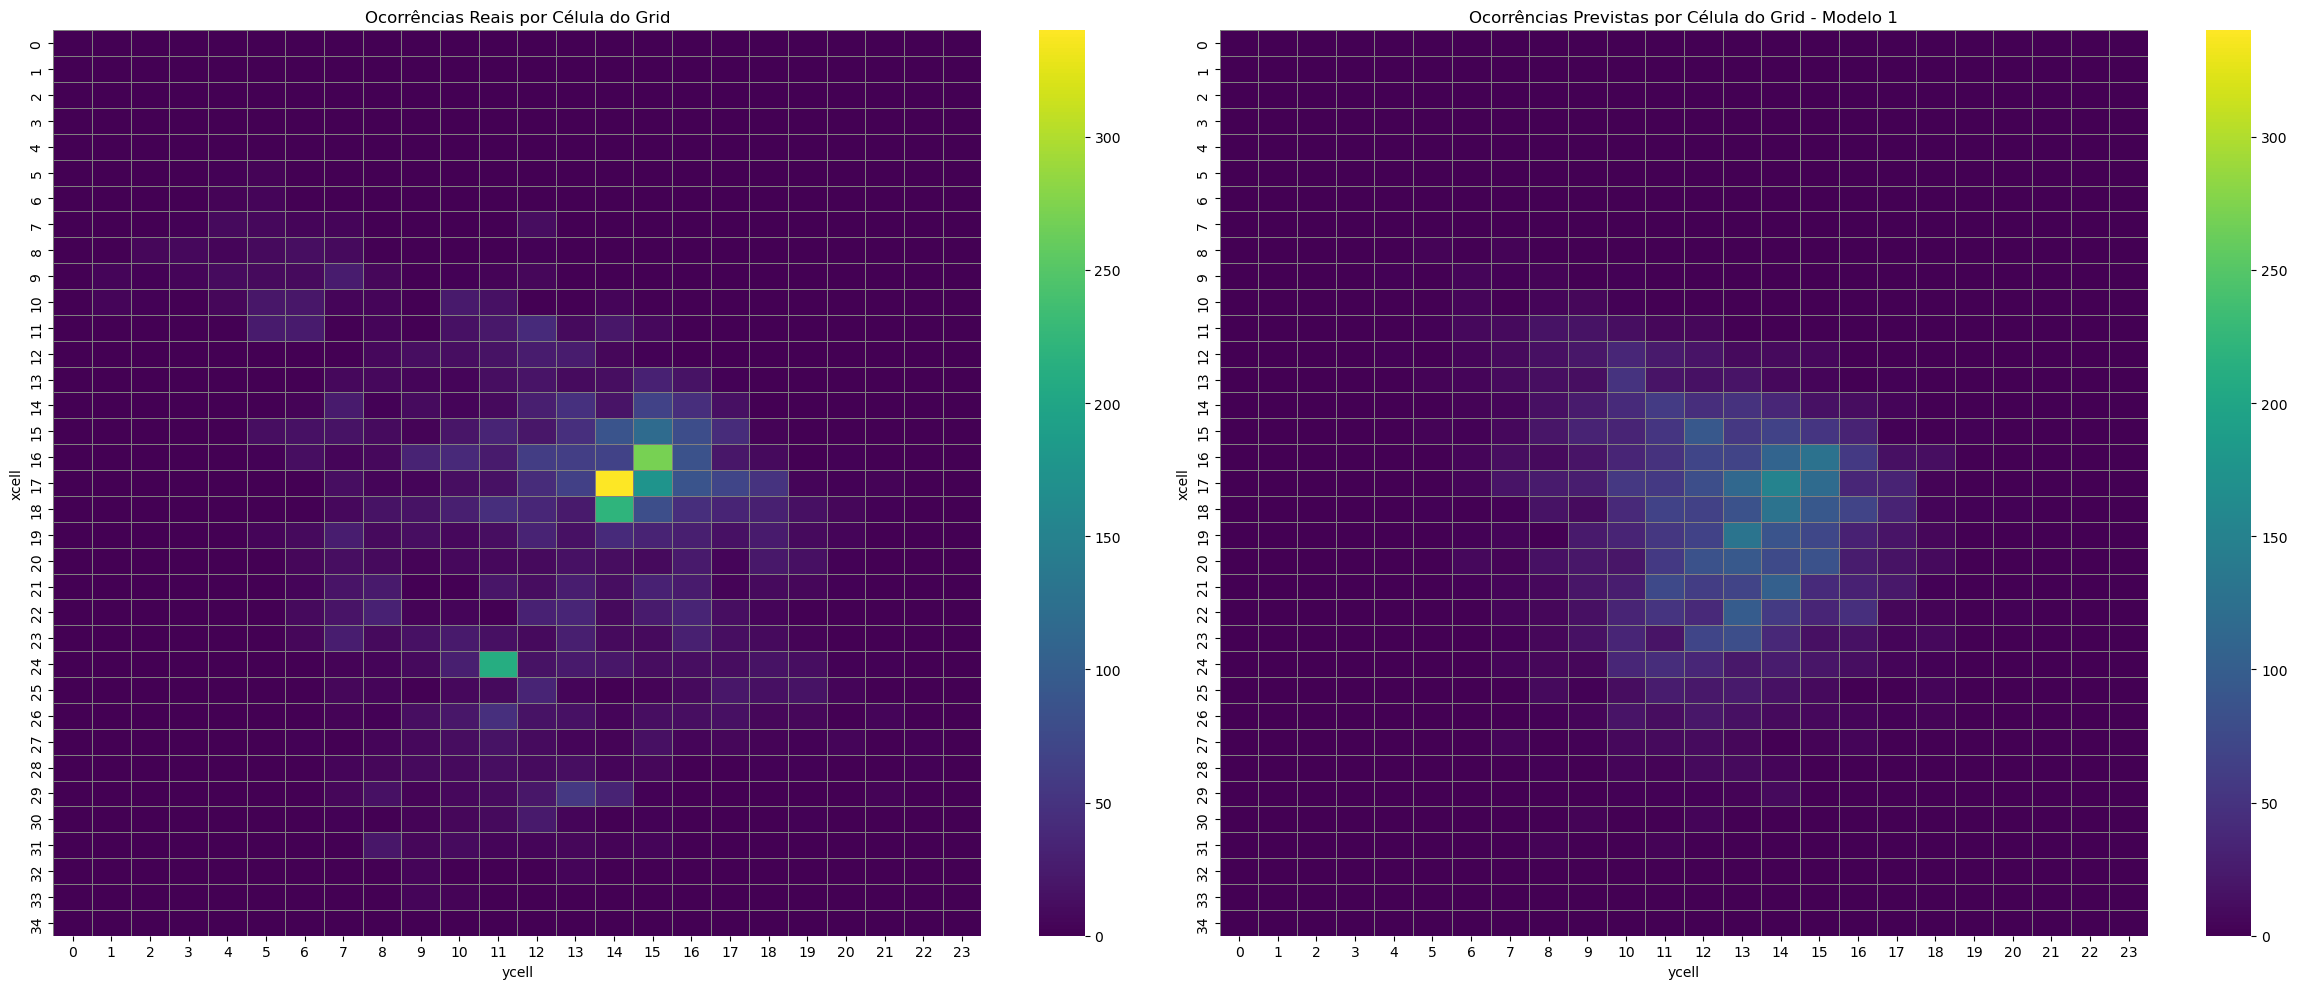

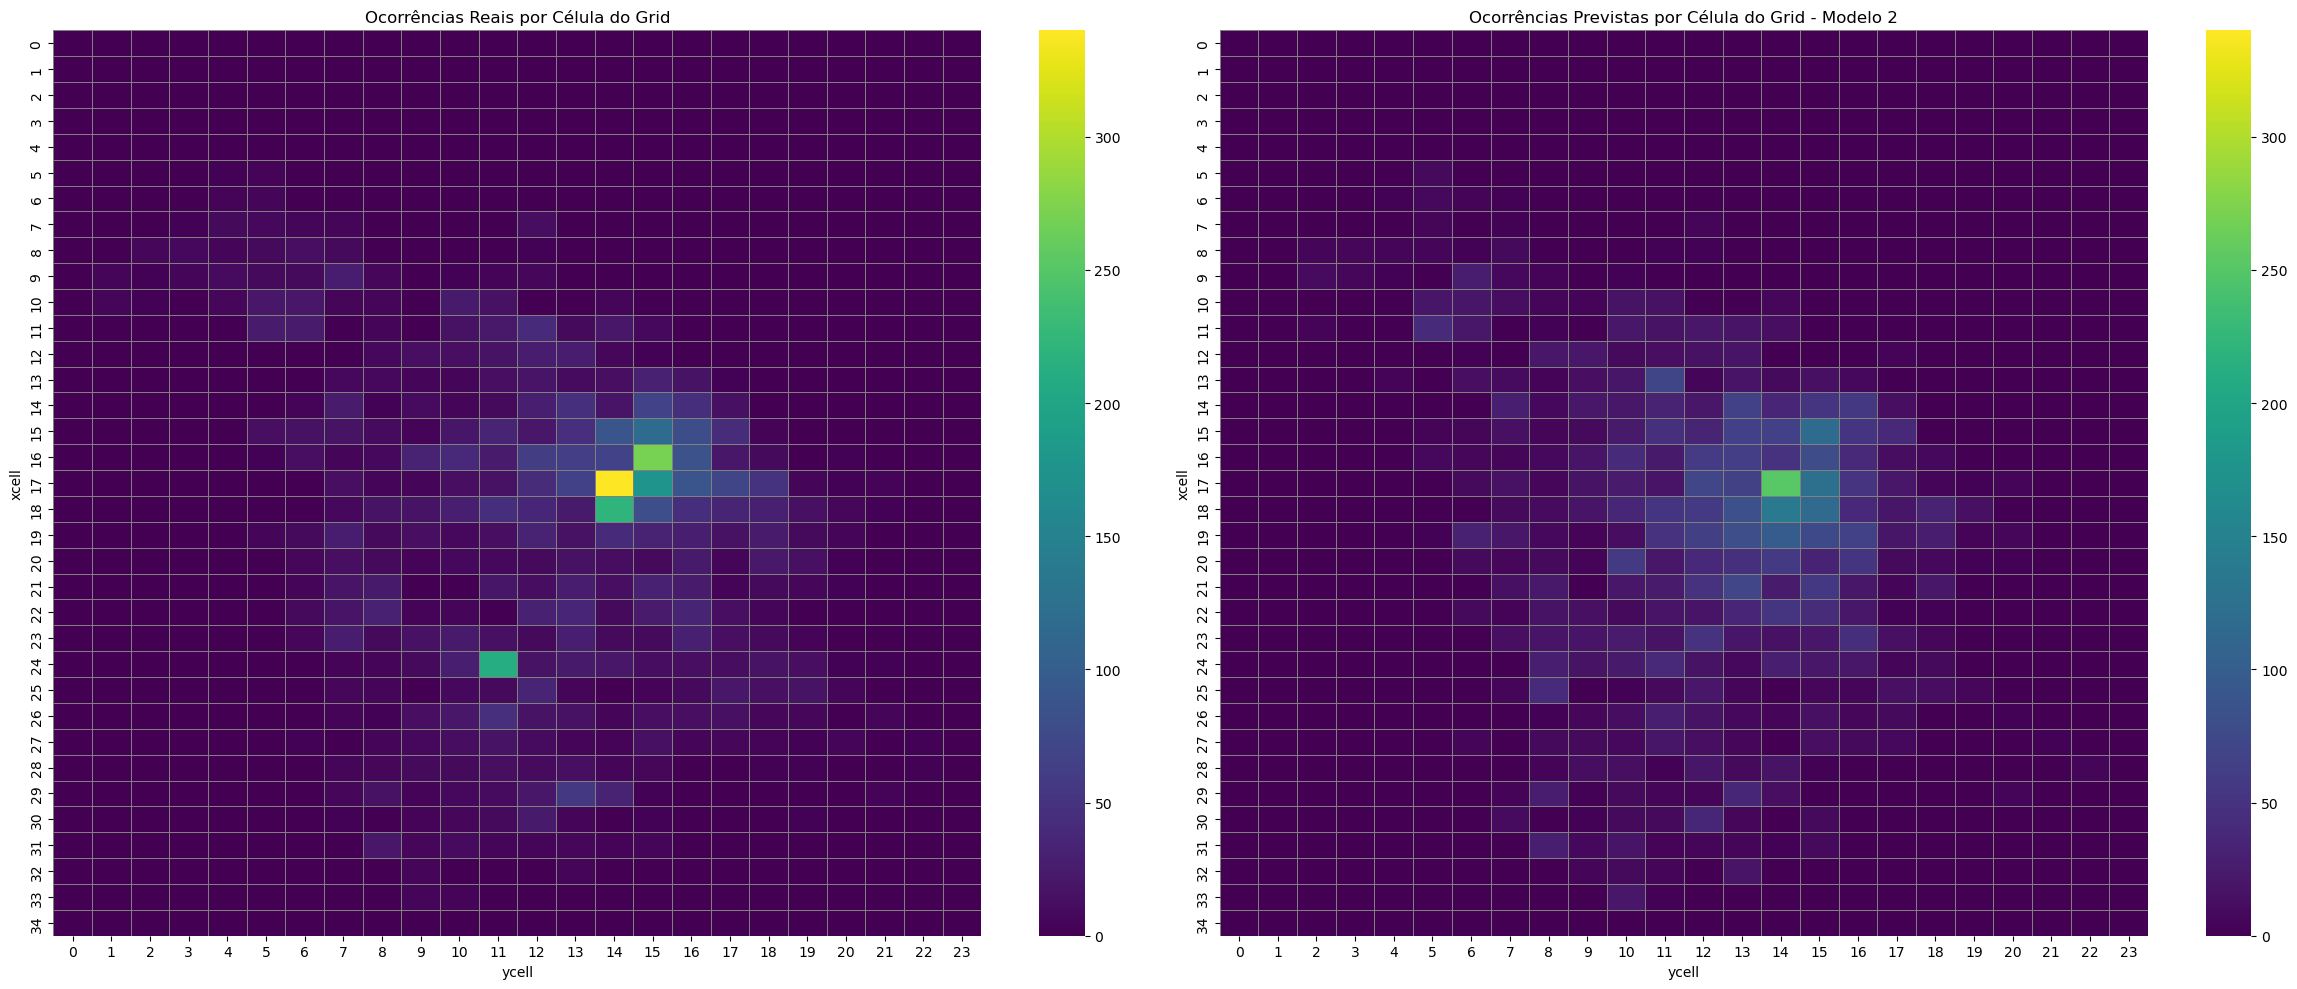

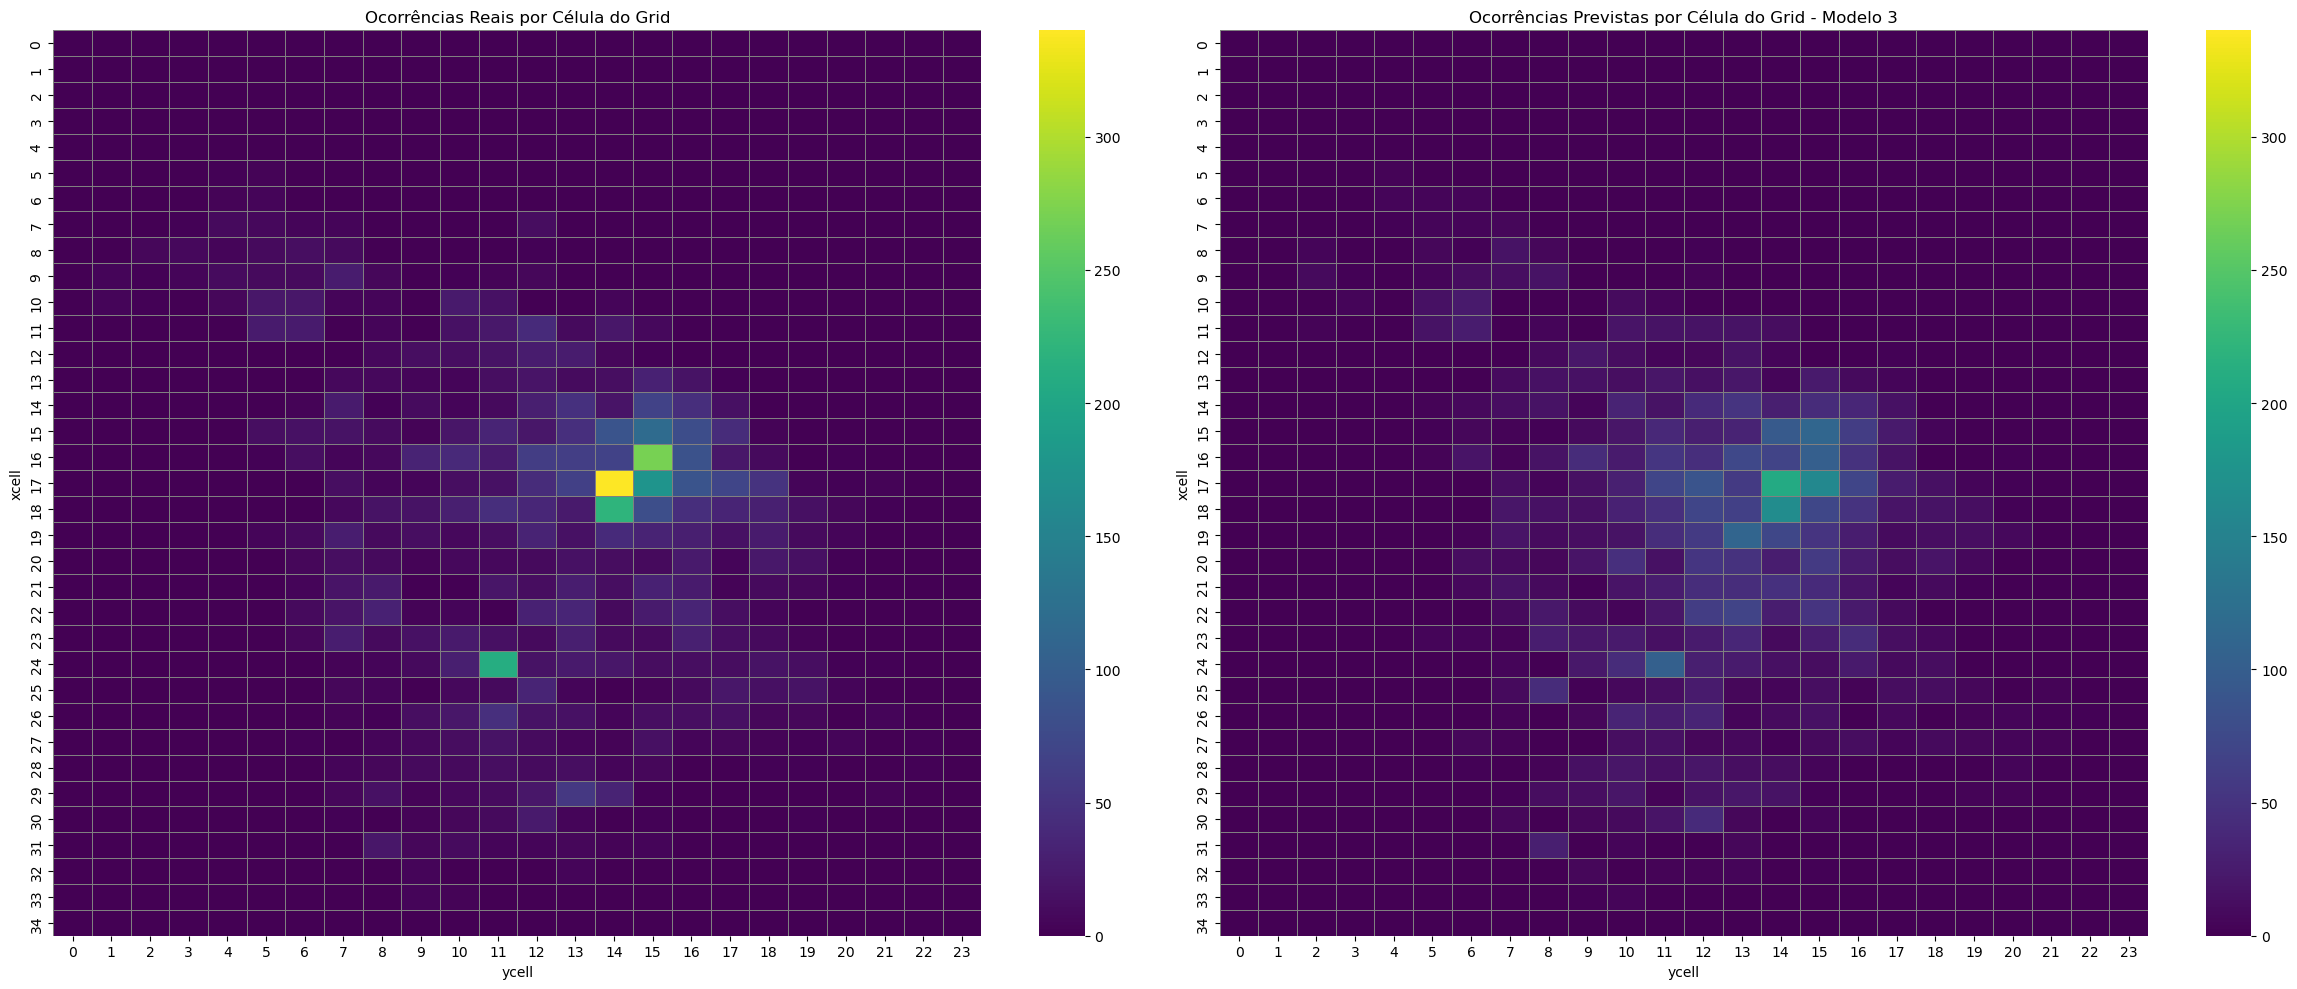

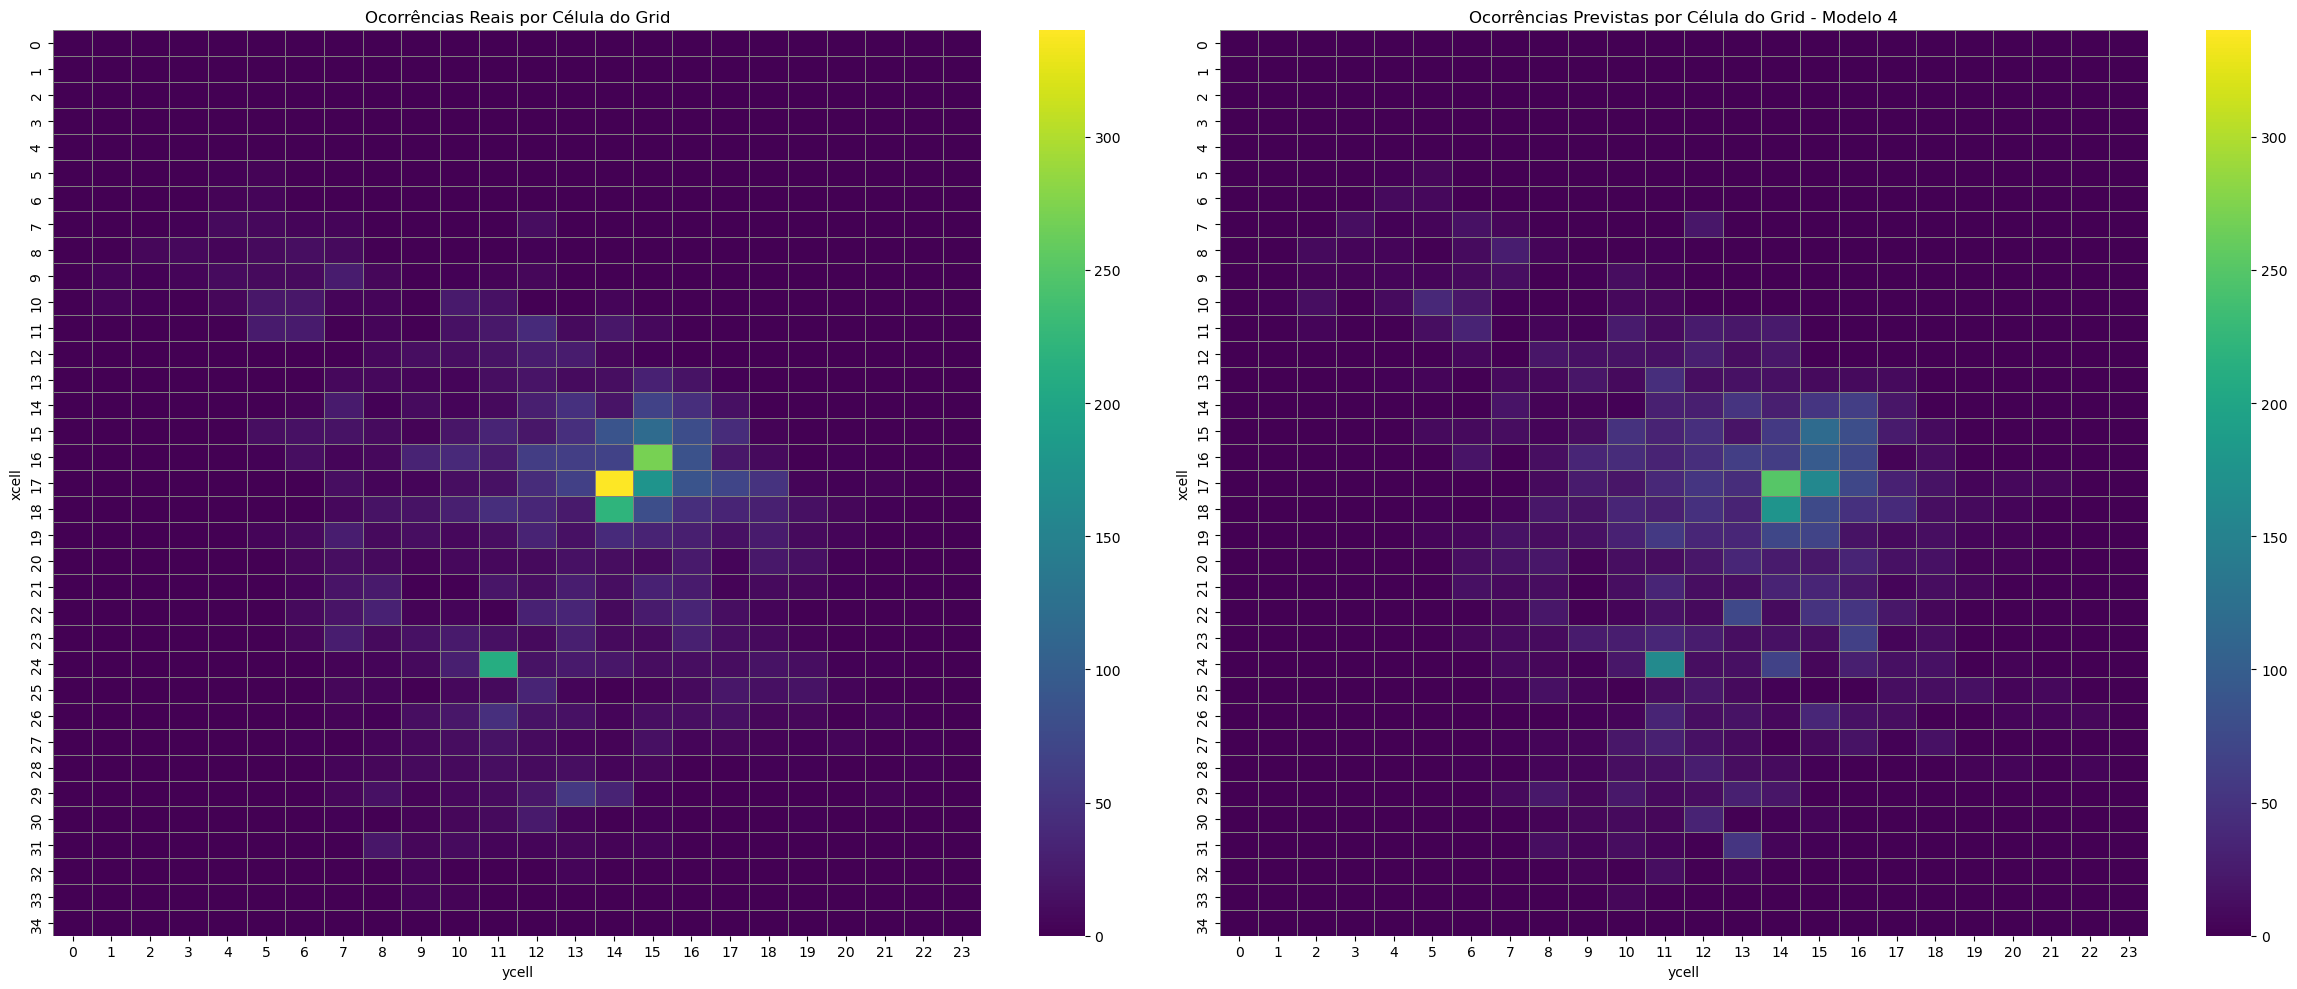

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def gerar_matriz_contagem(df_counts, grid):
    """
    Gera uma matriz de contagem por célula do grid usando 'xcell' e 'ycell' para localização.
    """
    # Mesclar com o grid para obter as coordenadas xcell e ycell para cada cell
    df_contagem_com_coordenadas = df_counts.merge(grid[['cell', 'xcell', 'ycell']], on='cell', how='left')
    
    # Criar a matriz de contagem usando xcell e ycell
    matriz_contagem = df_contagem_com_coordenadas.pivot_table(
        index='ycell', columns='xcell', values='count', fill_value=0
    )
    
    return matriz_contagem

def plotar_heatmap_comparativo(df_y_test_counts, df_pred_counts, grid, nome_modelo):
    """
    Plota heatmaps comparativos lado a lado para ocorrências reais e predições de um modelo.
    """
    # Obter os valores máximos de xcell e ycell para definir a matriz
    max_xcell = grid['xcell'].max()
    max_ycell = grid['ycell'].max()

    # Gerar as matrizes de contagem para as ocorrências reais e para as predições
    matriz_real_counts = gerar_matriz_contagem(df_y_test_counts, grid)
    matriz_pred_counts = gerar_matriz_contagem(df_pred_counts, grid)

    # Reindexar para garantir que todas as células estejam representadas nas matrizes
    full_index_x = np.arange(0, max_xcell + 1)
    full_index_y = np.arange(0, max_ycell + 1)
    matriz_real_counts = matriz_real_counts.reindex(index=full_index_y, columns=full_index_x, fill_value=0)
    matriz_pred_counts = matriz_pred_counts.reindex(index=full_index_y, columns=full_index_x, fill_value=0)

    # Definir a mesma escala de cor para ambos os heatmaps
    vmin = 0
    vmax = max(matriz_real_counts.values.max(), matriz_pred_counts.values.max())

    # Plotar os heatmaps lado a lado
    plt.figure(figsize=(24, 10))

    # Heatmap das ocorrências reais
    plt.subplot(1, 2, 1)
    sns.heatmap(matriz_real_counts.T, cmap='viridis', linewidths=.5, linecolor='gray', vmin=vmin, vmax=vmax)
    plt.title("Ocorrências Reais por Célula do Grid")
    plt.xlabel("ycell")
    plt.ylabel("xcell")

    # Heatmap das predições do modelo específico
    plt.subplot(1, 2, 2)
    sns.heatmap(matriz_pred_counts.T, cmap='viridis', linewidths=.5, linecolor='gray', vmin=vmin, vmax=vmax)
    plt.title(f"Ocorrências Previstas por Célula do Grid - {nome_modelo}")
    plt.xlabel("ycell")
    plt.ylabel("xcell")

    plt.tight_layout()
    plt.show()

nomes_modelos = ["Modelo 1", "Modelo 2", "Modelo 3", "Modelo 4"]

for df_pred_counts, nome_modelo in zip(dfs, nomes_modelos):
    plotar_heatmap_comparativo(df_y_test_counts, df_pred_counts, grid, nome_modelo)


## Resultados por granularidade

In [24]:
def agrupar_por_granularidade(df, coluna_tempo, granularidade):
    """
    Agrupa o DataFrame por uma granularidade de tempo especificada.
    
    Parâmetros:
    - df (DataFrame): O DataFrame original com uma coluna de timestamp.
    - coluna_tempo (str): O nome da coluna que contém os timestamps.
    - granularidade (str): A granularidade de agrupamento (ex: 'D' para dia, '8H' para 8 horas).
    
    Retorna:
    - lista_grupos (list): Uma lista de DataFrames, cada um contendo os dados de um grupo.
    """
    # Converter a coluna de tempo para datetime, caso ainda não esteja no formato correto
    # df[coluna_tempo] = pd.to_datetime(df[coluna_tempo])
    
    # Definir a coluna de tempo como índice temporário
    df = df.set_index(coluna_tempo)
    
    # Agrupar pelo índice de tempo, conforme a granularidade especificada
    grupos = df.groupby(pd.Grouper(freq=granularidade))
    
    # Criar uma lista de DataFrames, onde cada DataFrame é um grupo
    lista_grupos = [grupo for _, grupo in grupos if not grupo.empty]
    
    return lista_grupos


grupos_dia = agrupar_por_granularidade(df_teste, 'data_hora_fato', 'D')

grupos_8h = agrupar_por_granularidade(df_teste, 'data_hora_fato', '8h')


In [25]:
features = [
    'night_or_day', 'cos_hour', 'cos_day_of_week', 'day_of_week', 'sin_minute',
    'sin_day_of_week', 'day', 'month', 'hour', 'cos_minute', 
    'cos_month', 'year', 'sin_month', 'sin_hour'
]

target = ['numero_latitude', 'numero_longitude']  

grids = []
for i in range(200, 1001, 100):
    grid = create_grid(
        i,
        config["database"]["filters"]["nome_municipio"],
    )
    grids.append(grid)

results = []

grid_value = 200
for grid_curr in grids:
    day = 0
    print(f"Grid de {grid_value}\n")
    for df_dia in grupos_dia:
        if df_dia.shape[0] > 10:
            day=day+1
            print(f"Dia {day}\n")
            for model_name, model in models.items():
                predicoes = model.predict(df_dia[features])
                df_predicoes = pd.DataFrame(predicoes, columns=['numero_latitude', 'numero_longitude'])
                df_y_pred_counts = contar_ocorrencias_por_celula(df_predicoes, grid_curr, 'numero_latitude', 'numero_longitude')
                df_y_real_counts = contar_ocorrencias_por_celula(df_dia[target], grid_curr, 'numero_latitude', 'numero_longitude')
                print("Resultados modelo ", model_name)
                print(eval(df_y_real_counts, df_y_pred_counts, grid_value))
            print("\n")
    grid_value += 100
        

100%|██████████| 24/24 [00:00<00:00, 3338.75it/s]


Grid de 200

Dia 1

Resultados modelo  Random Forest Regressor
{'HR(10.0%)': 0.02912621359223301, 'ALS': 0.0, 'ALS_zeros': 120, 'MSE': 0.04070597837176086, 'PAI': 0.29132157717455914, 'PEI': 0.001535565682583713}
Resultados modelo  Extra Trees Regressor
{'HR(10.0%)': 0.11165048543689321, 'ALS': 0.025617594327711345, 'ALS_zeros': 86, 'MSE': 0.04815343807386248, 'PAI': 1.1167327125024769, 'PEI': 0.0019219338220725181}
Resultados modelo  Decision Tree Regressor
{'HR(10.0%)': 0.0970873786407767, 'ALS': 0.0224206589524104, 'ALS_zeros': 88, 'MSE': 0.05060191797592328, 'PAI': 0.9710719239151971, 'PEI': 0.0014563106796116503}
Resultados modelo  Bagging Regressor
{'HR(10.0%)': 0.09223300970873786, 'ALS': 0.02158746348467536, 'ALS_zeros': 72, 'MSE': 0.0602938175882473, 'PAI': 0.9225183277194373, 'PEI': 0.0022612443035466617}


Dia 2

Resultados modelo  Random Forest Regressor
{'HR(10.0%)': 0.0825242718446602, 'ALS': 0.0, 'ALS_zeros': 112, 'MSE': 0.03866557845337686, 'PAI': 0.8254111353279177, 'P

In [26]:
# Definir as listas de features e target
features = [
    'night_or_day', 'cos_hour', 'cos_day_of_week', 'day_of_week', 'sin_minute',
    'sin_day_of_week', 'day', 'month', 'hour', 'cos_minute', 
    'cos_month', 'year', 'sin_month', 'sin_hour'
]
target = ['numero_latitude', 'numero_longitude']  

# Criar os grids conforme os valores definidos
grids = []
for i in range(200, 1001, 100):
    grid = create_grid(i, config["database"]["filters"]["nome_municipio"])
    grids.append(grid)

# Lista para armazenar os resultados finais
resultados_finais = []

# Loop sobre os tamanhos de grid
grid_value = 200
for grid_curr in grids:
    print(f"Grid de {grid_value}\n")
    
    # Inicializar um dicionário para armazenar os resultados diários para cada modelo
    resultados_diarios = {model_name: [] for model_name in models.keys()}
    
    # Loop sobre os dias
    day = 0
    for df_dia in grupos_dia:
        if df_dia.shape[0] > 10:  # Processar somente se houver mais de 10 ocorrências no dia
            day += 1
            print(f"Dia {day}\n")
            
            # Loop sobre os modelos
            for model_name, model in models.items():
                # Fazer a predição e contar as ocorrências
                predicoes = model.predict(df_dia[features])
                df_predicoes = pd.DataFrame(predicoes, columns=['numero_latitude', 'numero_longitude'])
                df_y_pred_counts = contar_ocorrencias_por_celula(df_predicoes, grid_curr, 'numero_latitude', 'numero_longitude')
                df_y_real_counts = contar_ocorrencias_por_celula(df_dia[target], grid_curr, 'numero_latitude', 'numero_longitude')
                
                # Avaliar as predições e registrar os resultados diários
                resultado = eval(df_y_real_counts, df_y_pred_counts, grid_value)
                resultados_diarios[model_name].append(resultado)
                
                print("Resultados modelo ", model_name)
                print(resultado)
    
    # Calcular a média das métricas para cada modelo após os 31 dias
    for model_name, resultados in resultados_diarios.items():
        if resultados:  # Verificar se houve resultados (pode não ter 31 dias completos)
            # Converter a lista de dicionários para um DataFrame para facilitar o cálculo da média
            df_resultados = pd.DataFrame(resultados)
            media_metricas = df_resultados.mean().to_dict()
            
            # Adicionar informações sobre o grid e o modelo
            media_metricas['grid_size'] = grid_value
            media_metricas['model_name'] = model_name
            
            # Adicionar o resultado final ao DataFrame consolidado
            resultados_finais.append(media_metricas)
    
    # Incrementar o tamanho do grid
    grid_value += 100

# Criar o DataFrame final com os resultados
df_resultados_finais = pd.DataFrame(resultados_finais)

# Exibir o DataFrame final
print(df_resultados_finais)

100%|██████████| 24/24 [00:00<00:00, 2934.19it/s]


Grid de 200

Dia 1

Resultados modelo  Random Forest Regressor
{'HR(10.0%)': 0.02912621359223301, 'ALS': 0.0, 'ALS_zeros': 120, 'MSE': 0.04070597837176086, 'PAI': 0.29132157717455914, 'PEI': 0.001535565682583713}
Resultados modelo  Extra Trees Regressor
{'HR(10.0%)': 0.11165048543689321, 'ALS': 0.025617594327711345, 'ALS_zeros': 86, 'MSE': 0.04815343807386248, 'PAI': 1.1167327125024769, 'PEI': 0.0019219338220725181}
Resultados modelo  Decision Tree Regressor
{'HR(10.0%)': 0.0970873786407767, 'ALS': 0.0224206589524104, 'ALS_zeros': 88, 'MSE': 0.05060191797592328, 'PAI': 0.9710719239151971, 'PEI': 0.0014563106796116503}
Resultados modelo  Bagging Regressor
{'HR(10.0%)': 0.09223300970873786, 'ALS': 0.02158746348467536, 'ALS_zeros': 72, 'MSE': 0.0602938175882473, 'PAI': 0.9225183277194373, 'PEI': 0.0022612443035466617}
Dia 2

Resultados modelo  Random Forest Regressor
{'HR(10.0%)': 0.0825242718446602, 'ALS': 0.0, 'ALS_zeros': 112, 'MSE': 0.03866557845337686, 'PAI': 0.8254111353279177, 'PEI

In [27]:
df_resultados_finais.head(40)

,HR(10.0%),ALS,ALS_zeros,MSE,PAI,PEI,grid_size,model_name
0,0.051755,0.009370,108.548387,0.080365,0.517653,0.002347,200,Random Forest Regressor
1,0.098823,0.024227,78.000000,0.092976,0.988431,0.002081,200,Extra Trees Regressor
2,0.096528,0.022023,82.548387,0.087793,0.965478,0.002365,200,Decision Tree Regressor
3,0.112624,0.024707,77.000000,0.077881,1.126474,0.002465,200,Bagging Regressor
4,0.101814,0.023196,100.580645,0.194851,1.018607,0.009635,300,Random Forest Regressor
5,0.165874,0.051574,70.096774,0.217740,1.659496,0.008458,300,Extra Trees Regressor
6,0.160601,0.047222,74.290323,0.202639,1.606738,0.009989,300,Decision Tree Regressor
7,0.168593,0.043780,69.806452,0.195100,1.686694,0.008532,300,Bagging Regressor
8,0.157343,0.040941,91.096774,0.369691,1.575003,0.026384,400,Random Forest Regressor
9,0.214974,0.074772,64.741935,0.410652,2.151890,0.021379,400,Extra Trees Regressor
